## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
# %matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
calibration_data = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
pickle.dump(calibration_data, open('../calibration_data.pkl', 'wb'))

## And so on and so forth...

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
# Calculate undistorted image
def cal_undistort(img, mtx=None, dist=None):   
    undist = cv2.undistort(img, mtx, dist, None, mtx) 
    return undist

In [2]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, abs_thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobel = np.absolute(sobel)
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1
    # plt.imshow(sxbinary, cmap='gray')
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output

In [3]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [4]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [5]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [6]:
# Apply perspective transform
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    # source coordinates
    src = np.float32([[293, 668], [587, 458], [703, 458], [1028, 668]])
    dst = np.float32([[175, 720],
                     [175, 0],
                     [950, 0],
                     [950, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv

In [7]:
def fit_polynomial(img, nwindows=9, plotit=False):
    """
    Finds the line with the help of an histogram and fits a second order polynomial
    """
    
    binary_warped = img
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    # Set height of windows
    window_height = np.int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                      (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
                      (win_xright_high, win_y_high), (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (
            nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (
            nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean
        # position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[
                        0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + \
        right_fit[1] * ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[
        left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[
        right_lane_inds]] = [0, 0, 255]
    
    mpimg.imsave('../output_images/polynomial.jpg', out_img)
    if plotit:
        plt.imshow(out_img / 255)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    return left_fit, right_fit, left_fitx, right_fitx, (leftx, lefty, rightx, righty, ploty)

In [8]:
def fit_poly_continuos(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin))).nonzero()[0]
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin))).nonzero()[0]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    print(np.vstack([left_fitx-margin, ploty]))
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return left_fit, right_fit, (leftx, lefty, rightx, righty, ploty)

In [9]:
def measure_curvature(img, left_fitx, right_fitx, fits):
    '''
    Calculates the curvature of polynomial functions
    '''
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    y_eval = img.shape[0]
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(fits[1] * ym_per_pix, fits[0] * xm_per_pix, 2)
    right_fit_cr = np.polyfit(fits[3] * ym_per_pix, fits[2] * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[
                     1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[
                      1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
    lane_center = (left_fitx[-1] + right_fitx[-1]) / 2
    # Offset from center
    offset = (img.shape[1]/2 - lane_center) * xm_per_pix
    return left_curverad, right_curverad, offset

In [10]:
def warp_perspective_back(warped, undist, left_fit, right_fit, fits, Minv):
    """
    Warps perspective back to original view and draws lane area
    
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_fit[0] * fits[4]**2 + left_fit[1] * fits[4] + left_fit[2]
    right_fitx = right_fit[0] * fits[4]**2 + right_fit[1] * fits[4] + right_fit[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, fits[4]]))])
    pts_right = np.array(
        [np.flipud(np.transpose(np.vstack([right_fitx, fits[4]])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective
    # matrix (Minv)
    newwarp = cv2.warpPerspective(
        color_warp, Minv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
#     plt.imshow(result)
    return result

In [11]:
# Load test images and correct distortion
import glob
ret, mtx, dist, rvecs, tvecs = pickle.load(open('../calibration_data.pkl', 'rb'))
test_images = glob.glob('../test_images/*.jpg')
images = []
for i, img_path in enumerate(test_images):
    undistorted_img = cal_undistort(mpimg.imread(img_path),mtx=mtx,dist=dist)
    mpimg.imsave(f'../output_images/undistorted_{i}.jpg', undistorted_img)
    images.append(undistorted_img)

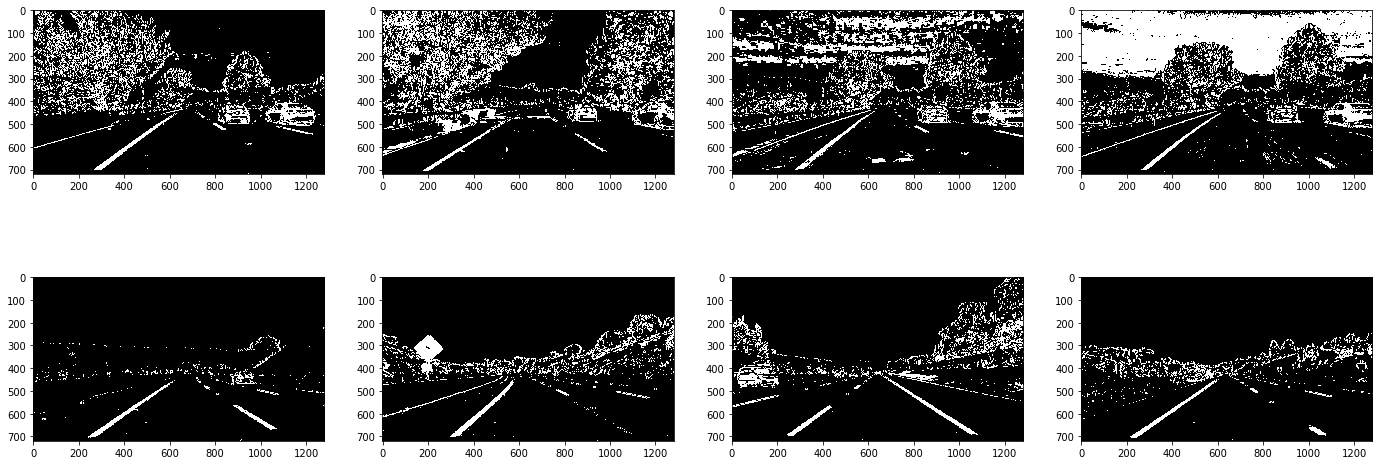

In [12]:
# Apply thershold and color gradients on all of em
ksize = 15 # sobel kernel size
f, axes = plt.subplots(2, np.uint8(len(images)/2), figsize=(24,9))
axes = axes.ravel()
grad_imgs = []
for i, image in enumerate(images):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, abs_thresh=(20, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, abs_thresh=(70, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(-np.pi/2, 1))
    hls_binary = hls_select(image, thresh=(120, 255))
    gradients_binary = np.zeros_like(dir_binary)
    gradients_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined_binary = np.zeros_like(gradients_binary)
    combined_binary[(gradients_binary == 1) | (hls_binary == 1)] = 1
    mpimg.imsave(f'../output_images/combined_binary_{i}.jpg', combined_binary, cmap='gray')
    grad_imgs.append(combined_binary)
    color_binary = np.dstack(( np.zeros_like(gradients_binary), gradients_binary, hls_binary)) * 255
    axes[i].imshow(combined_binary, cmap='gray')
    

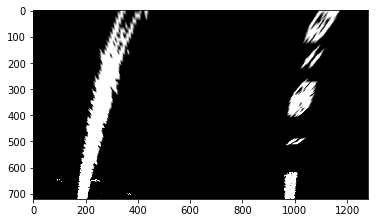

In [13]:
# top view of the image
warped, Minv = warp(grad_imgs[4])
mpimg.imsave('../output_images/warped_4.jpg', warped)
plt.imshow(warped, cmap='gray')

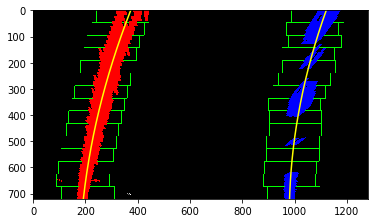

In [14]:
left_fit, right_fit, left_fitx, right_fitx, fits = fit_polynomial(warped, plotit=True, nwindows=15)

In [15]:
left_curverad, right_curverad, x_offset = measure_curvature(warped, left_fitx, right_fitx, fits)

In [16]:
left_curverad, right_curverad

(847.4833050380178, 717.7903247727)

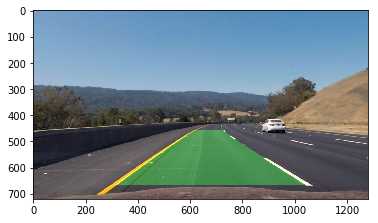

In [17]:
result = warp_perspective_back(warped, images[4], left_fit, right_fit, fits, Minv)
mpimg.imsave('../output_images/warped_back_4.jpg', result)
plt.imshow(result)

In [18]:
left_fit_g, right_fit_g, curvature_g = [], [], []
def smooth_curvature(curvature, n=50):
    """
    Smoothes the curvature over n frames
    """
    curvature_g.append(curvature)
    curvature_np = np.array(curvature_g)

    if len(curvature_g) > n:
        curvature = np.mean(curvature_np[-n:])

    return curvature

def smooth_fits(left_fit, right_fit, n=20):
    """
    Smoothes the polynomial fits
    """
    left_fit_g.append(left_fit)
    right_fit_g.append(right_fit)

    left_fit_np = np.array(left_fit_g)
    right_fit_np = np.array(right_fit_g)

    if len(left_fit_g) > n:
        left_fit = np.mean(left_fit_np[-n:, :], axis=0)
    if len(right_fit_g) > n:
        right_fit = np.mean(right_fit_np[-n:, :], axis=0)
    return left_fit, right_fit

def process_frame(img):
    undistorted = cal_undistort(img,mtx=mtx,dist=dist)
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=15, abs_thresh=(20, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=15, abs_thresh=(70, 255))
    mag_binary = mag_thresh(img, sobel_kernel=15, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(-np.pi/2, 1))
    hls_binary = hls_select(img, thresh=(120, 255))
    gradients_binary = np.zeros_like(dir_binary)
    gradients_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined_binary = np.zeros_like(gradients_binary)
    combined_binary[(gradients_binary == 1) | (hls_binary == 1)] = 1
    color_binary = np.dstack(( np.zeros_like(gradients_binary), gradients_binary, hls_binary)) * 255
    warped, Minv = warp(combined_binary)
    left_fit, right_fit, left_fitx, right_fitx, fits = fit_polynomial(warped, plotit=False, nwindows=15)
    left_fit, right_fit = smooth_fits(left_fit, right_fit)
    left_curverad, right_curverad, x_offset = measure_curvature(warped, left_fitx, right_fitx, fits)
    left_curverad = smooth_curvature(left_curverad)
    left_curverad_text = f"Radius of Curvature = {left_curverad:.2f}"
    offset_text = f"Vehicle is {x_offset:.2f}m left of center"
    result = warp_perspective_back(warped, undistorted, left_fit, right_fit, fits, Minv)
    cv2.putText(result, left_curverad_text, (200, 100), 0, 1.2, (255, 255, 0), 2)
    cv2.putText(result, offset_text, (200, 200), 0, 1.2, (255, 255, 0), 2)
    return result

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_video_out.mp4'
# clip1 = VideoFileClip("../project_video.mp4").subclip(20,)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [09:07<00:00,  2.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 8min 15s, sys: 1min 43s, total: 9min 58s
Wall time: 9min 8s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))